🧩 TAHAP 1 – Membangun Case Base

In [ ]:
# Install poppler untuk mendukung pdftotext (Colab Only)
!apt-get install -y poppler-utils

import os
import zipfile
import re
import subprocess
from pathlib import Path

# ==== 1. SETUP & EKSTRAK FILE ZIP ====
zip_file = "/content/cbr_data.zip"  # ← Pastikan nama file ZIP kamu benar
extract_path = "/content/cbr_project"

# Ekstrak isi ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Buat folder output
raw_dir = Path("/content/data/raw")
log_dir = Path("/content/logs")
raw_dir.mkdir(parents=True, exist_ok=True)
log_dir.mkdir(parents=True, exist_ok=True)

# ==== 2. FUNGSI PEMBERSIH TEKS ====
def clean_text(text):
    text = text.lower()  # huruf kecil semua
    text = text.replace('\xa0', ' ')  # hapus karakter non-breaking space
    text = re.sub(r'\n\s*\n+', '\n', text)  # hapus baris kosong berulang
    text = re.sub(r'\s{2,}', ' ', text)  # spasi ganda jadi satu
    text = re.sub(r'page \d+ of \d+', '', text)  # hapus footer halaman
    text = re.sub(r'\d+/\d+', '', text)  # hapus format nomor halaman
    text = re.sub(r'\f', '', text)  # hapus karakter formfeed
    return text.strip()

# ==== 3. EKSTRAK PDF → TXT + CLEANING + LOG ====
log_file = open(log_dir / "cleaning.log", "w", encoding="utf-8")
min_word_count = 1000  # ambang batas minimal kelengkapan isi dokumen

pdf_files = sorted(Path(extract_path).rglob("*.pdf"))

for i, pdf in enumerate(pdf_files):
    txt_path = raw_dir / f"case_{i+1:03d}.txt"

    # Jalankan pdftotext → simpan file sementara
    subprocess.run(["pdftotext", str(pdf), str(txt_path)])

    # Baca hasil teks & bersihkan
    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            raw_text = f.read()

        cleaned = clean_text(raw_text)
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(cleaned)

        # Validasi isi
        word_count = len(cleaned.split())
        if word_count < min_word_count:
            log_file.write(f"{pdf.name} → {txt_path.name} (⚠️ kemungkinan kurang dari 80%)\n")
        else:
            log_file.write(f"{pdf.name} → {txt_path.name}\n")
    except Exception as e:
        log_file.write(f"{pdf.name} → ERROR: {e}\n")

log_file.close()
print(f"Selesai memproses {len(pdf_files)} dokumen. Log disimpan di: /content/logs/cleaning.log")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Selesai memproses 30 dokumen. Log disimpan di: /content/logs/cleaning.log


🧩 TAHAP 2 – Case Representation

In [ ]:
import pandas as pd
import re
from pathlib import Path

# === SETUP FOLDER ===
raw_dir = Path("/content/data/raw")
processed_dir = Path("/content/data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# === EKSTRAKSI & REPRESENTASI ===
data = []
for file in sorted(raw_dir.glob("*.txt")):
    with open(file, "r", encoding="utf-8") as f:
        text = f.read()

    case_id = file.stem
    no_perkara = re.search(r'\d+/\w+/\d{4}', text)
    tanggal = re.search(r'\d{4}-\d{2}-\d{2}', text)
    pasal = re.findall(r'pasal\s+\d+', text, re.IGNORECASE)
    pihak = re.search(r'(penggugat|tergugat|jaksa)[^\n]{1,80}', text, re.IGNORECASE)
    argumen = re.search(r'(memutuskan|mengadili)[^\n]{0,100}', text, re.IGNORECASE)

    data.append({
        "case_id": case_id,
        "no_perkara": no_perkara.group(0) if no_perkara else "",
        "tanggal": tanggal.group(0) if tanggal else "",
        "ringkasan_fakta": text[:500],
        "pasal": "; ".join(pasal),
        "pihak": pihak.group(0) if pihak else "",
        "argumen_hukum": argumen.group(0) if argumen else "",
        "length": len(text.split()),
        "text_full": text
    })

# === SIMPAN FILE CSV & JSON ===
df = pd.DataFrame(data)
csv_path = processed_dir / "cases.csv"
json_path = processed_dir / "cases.json"

df.to_csv(csv_path, index=False)
df.to_json(json_path, orient="records", indent=2)

# === OUTPUT TAMBAHAN UNTUK PENGGUNA ===
print("✅ Representasi kasus berhasil disimpan!")
print(f"🗂️ Total dokumen diproses: {len(df)}")
print(f"📄 File CSV: {csv_path}")
print(f"📄 File JSON: {json_path}")

if len(df) < 30:
    print("⚠️ PERINGATAN: Jumlah kasus < 30. Data belum memenuhi syarat")


✅ Representasi kasus berhasil disimpan!
🗂️ Total dokumen diproses: 30
📄 File CSV: /content/data/processed/cases.csv
📄 File JSON: /content/data/processed/cases.json


TAHAP 3 – Case Retrieval

In [ ]:
import os
os.makedirs("/content/data/eval", exist_ok=True)


In [ ]:
# Install library jika belum
!pip install scikit-learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import os

# === SETUP & BACA DATA ===
df = pd.read_csv("/content/data/processed/cases.csv")

# === SPLITTING DATA TRAIN & TEST ===
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"✅ Jumlah data train: {len(train_df)} | test: {len(test_df)}")

# === VEKTORISASI DENGAN TF-IDF ===
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["text_full"])

# === FUNGSI RETRIEVE ===
def retrieve(query: str, k: int = 5):
    """
    Ambil top-k dokumen yang paling mirip dengan query berdasarkan cosine similarity
    """
    query_vec = vectorizer.transform([query])
    sim = cosine_similarity(query_vec, X_train)[0]
    top_k_idx = sim.argsort()[-k:][::-1]
    return train_df.iloc[top_k_idx]["case_id"].tolist()

# === SIAPKAN QUERY UJI (DARI TEST SET) ===
query_data = []
for i, row in test_df.reset_index().iterrows():
    query_data.append({
        "query_id": int(i),
        "text": row["text_full"],
        "ground_truth_case_id": row["case_id"]
    })

# === SIMPAN KE FILE JSON ===
eval_dir = "/content/data/eval"
os.makedirs(eval_dir, exist_ok=True)
json_path = os.path.join(eval_dir, "queries.json")

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(query_data, f, indent=2, ensure_ascii=False)

# === CETAK OUTPUT VALIDASI ===
print("✅ Retrieval setup selesai.")
print(f"📁 Query uji disimpan di: {json_path}")
print("📋 Contoh hasil retrieve:")
sample = query_data[0]
print(f"\n📌 Query ID: {sample['query_id']}")
print(f"🎯 Ground Truth: {sample['ground_truth_case_id']}")
print("🔍 Top 5 hasil retrieve:", retrieve(sample['text'], k=5))


✅ Jumlah data train: 21 | test: 9
✅ Retrieval setup selesai.
📁 Query uji disimpan di: /content/data/eval/queries.json
📋 Contoh hasil retrieve:

📌 Query ID: 0
🎯 Ground Truth: case_028
🔍 Top 5 hasil retrieve: ['case_004', 'case_005', 'case_027', 'case_020', 'case_006']


🧩 TAHAP 4 – Solution Reuse

In [ ]:
import os
os.makedirs("/content/data/results", exist_ok=True)


In [ ]:
import json
import pandas as pd
import os
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# === PERSIAPAN DATA ===
with open("/content/data/eval/queries.json", "r") as f:
    queries = json.load(f)

df = pd.read_csv("/content/data/processed/cases.csv")
case_solutions = dict(zip(df["case_id"], df["ringkasan_fakta"]))

# Pastikan vectorizer dan X_train dari TF-IDF sudah tersedia (dari tahap 3)
# Jika belum, impor ulang dari 03_retrieval.py

# === FUNGSI: PREDIKSI DENGAN MAJORITY VOTE ===
def predict_outcome_majority(query: str, k: int = 5):
    top_k = retrieve(query, k)
    solutions = [case_solutions.get(cid, "") for cid in top_k]
    return Counter(solutions).most_common(1)[0][0], top_k

# === FUNGSI: PREDIKSI DENGAN WEIGHTED SIMILARITY ===
def predict_outcome_weighted(query: str, k: int = 5):
    query_vec = vectorizer.transform([query])
    sim = cosine_similarity(query_vec, X_train)[0]
    top_k_idx = sim.argsort()[-k:][::-1]

    weighted = {}
    for idx in top_k_idx:
        cid = train_df.iloc[idx]["case_id"]
        sol = case_solutions.get(cid, "")
        weighted[sol] = weighted.get(sol, 0) + sim[idx]

    sorted_weighted = sorted(weighted.items(), key=lambda x: x[1], reverse=True)
    top_k_ids = [train_df.iloc[i]["case_id"] for i in top_k_idx]
    return sorted_weighted[0][0], top_k_ids

# === PREDIKSI SEMUA QUERY (KEDUA METODE) ===
results = []
for q in queries:
    pred_majority, top_majority = predict_outcome_majority(q["text"])
    pred_weighted, top_weighted = predict_outcome_weighted(q["text"])
    results.append({
        "query_id": q["query_id"],
        "predicted_majority": pred_majority,
        "predicted_weighted": pred_weighted,
        "top_5_case_ids_majority": top_majority,
        "top_5_case_ids_weighted": top_weighted,
        "ground_truth_case_id": q["ground_truth_case_id"]
    })

# === SIMPAN HASIL KE CSV ===
os.makedirs("/content/data/results", exist_ok=True)
pd.DataFrame(results).to_csv("/content/data/results/predictions.csv", index=False)
print("✅ Hasil prediksi disimpan di: /content/data/results/predictions.csv")

# === DEMO MANUAL 5 QUERY ===
print("\n📊 Demo Manual (5 contoh query):\n")
for row in results[:5]:
    print(f"🔎 Query ID {row['query_id']}")
    print(f"🎯 Ground Truth: {row['ground_truth_case_id']}")
    print(f"✅ Majority Prediction: {row['predicted_majority']}")
    print(f"⭐ Weighted Prediction: {row['predicted_weighted']}")
    print(f"📄 Top-5 (majority): {row['top_5_case_ids_majority']}")
    print("-" * 60)


✅ Hasil prediksi disimpan di: /content/data/results/predictions.csv

📊 Demo Manual (5 contoh query):

🔎 Query ID 0
🎯 Ground Truth: case_028
✅ Majority Prediction: ep
u
b
hk
am
direktori putusan mahkamah agung republik indonesia
r
putusan
ng
nomor 131/pid.sus-tpk/2024/pn sby
demi keadilan berdasarkan ketuhanan yang maha esa
gu
perkara pidana khusus.
pengadilan tindak pidana korupsi pada pengadilan negeri surabaya
a
yang mengadili perkara pidana dengan acara pemeriksaan biasa secara
inabsentia dalam tingkat pertama menjatuhkan putusan sebagai berikut dalam
: bastian widjaja.
2. tempat lahir
: surabaya.
3. umur/tanggal lahir
: 48 tahun / 1 nopember 1976.
4. 
⭐ Weighted Prediction: ep
u
b
hk
am
direktori putusan mahkamah agung republik indonesia
r
putusan
ng
nomor 131/pid.sus-tpk/2024/pn sby
demi keadilan berdasarkan ketuhanan yang maha esa
gu
perkara pidana khusus.
pengadilan tindak pidana korupsi pada pengadilan negeri surabaya
a
yang mengadili perkara pidana dengan acara pemeriksaan bia

🧩 TAHAP 5 – Model Evaluation

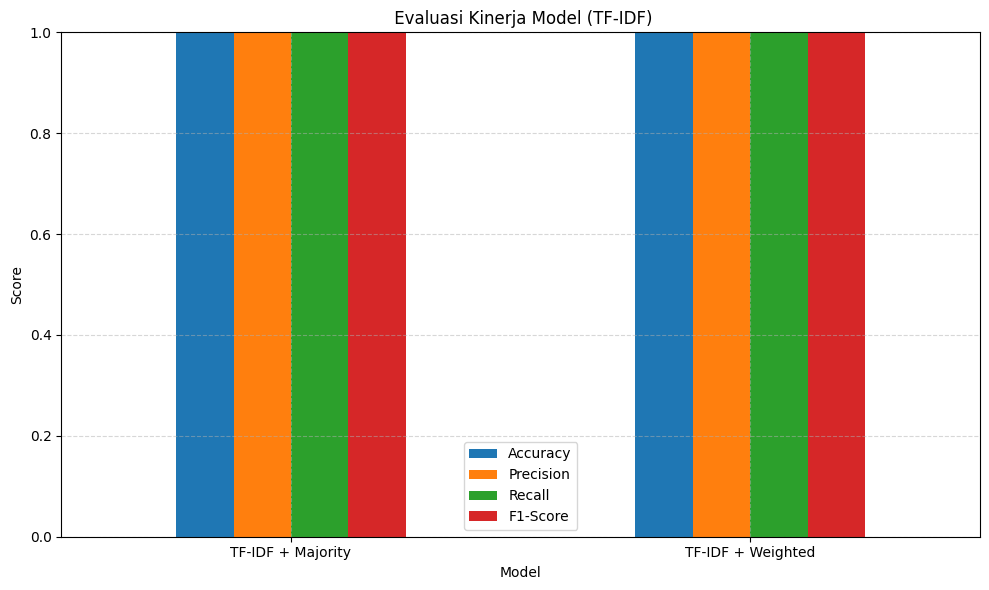


❌ Kasus Gagal Prediksi (Majority Vote):

✅ Evaluasi lengkap selesai. Hasil disimpan di /content/data/eval/


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast

# === BACA DATA PREDIKSI ===
df = pd.read_csv("/content/data/results/predictions.csv")

# Parse string list jadi list Python
df["top_5_case_ids_majority"] = df["top_5_case_ids_majority"].apply(ast.literal_eval)
df["top_5_case_ids_weighted"] = df["top_5_case_ids_weighted"].apply(ast.literal_eval)

# Ambil ground-truth dan prediksi top-1
y_true = df["ground_truth_case_id"]
y_pred_majority = df["top_5_case_ids_majority"].str[0]
y_pred_weighted = df["top_5_case_ids_weighted"].str[0]

# === FUNGSI METRIK ===
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

# Hitung metrik untuk masing-masing model
metrics_majority = get_metrics(y_true, y_pred_majority)
metrics_weighted = get_metrics(y_true, y_pred_weighted)

# Gabungkan jadi tabel
eval_df = pd.DataFrame([
    {"Model": "TF-IDF + Majority", **metrics_majority},
    {"Model": "TF-IDF + Weighted", **metrics_weighted}
])

# === SIMPAN CSV ===
os.makedirs("/content/data/eval", exist_ok=True)
eval_df.to_csv("/content/data/eval/retrieval_metrics.csv", index=False)

# === VISUALISASI: Bar Chart ===
eval_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot.bar(
    figsize=(10, 6), title=" Evaluasi Kinerja Model (TF-IDF)"
)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("/content/data/eval/evaluation_chart.png")
plt.show()

# === ERROR ANALYSIS: Tampilkan Query Gagal Prediksi ===
print("\n❌ Kasus Gagal Prediksi (Majority Vote):\n")
for i, (gt, pred) in enumerate(zip(y_true, y_pred_majority)):
    if gt != pred:
        print(f"🔹 Query ID: {df['query_id'][i]}")
        print(f"   ✅ Ground Truth: {gt}")
        print(f"   ❌ Predicted: {pred}\n")

print("✅ Evaluasi lengkap selesai. Hasil disimpan di /content/data/eval/")


In [ ]:
import os
import shutil

# Buat folder jika belum ada
os.makedirs("/content/data/results", exist_ok=True)

# Pindahkan file ke folder
shutil.move("/content/predictions_updated.csv", "/content/data/results/predictions.csv")


'/content/data/results/predictions.csv'

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving predictions_updated.csv to predictions_updated.csv
